## Load IPython support for working with MPI tasks

In [53]:
from ipyparallel import Client, error
cluster = Client()
view = cluster[:]

Let's also load the plotting and numerical libraries so we have them ready for visualization later on.

In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Now, we load the MPI libraries into the engine namespaces, and do a simple printing of their MPI rank information to verify that all nodes are operational and they match our cluster's real capacity.  

Here, we are making use of IPython's special `%%px` cell magic, which marks the entire cell for parallel execution.  This means that the code below will not run in this notebook's kernel, but instead will be sent to *all* engines for execution there.  In this way, IPython makes it very natural to control your entire cluster from within the notebook environment:

In [55]:
%%px
# MPI initialization, library imports and sanity checks on all engines
from mpi4py import MPI
# Load data publication API so engines can send data to notebook client
from ipykernel.datapub import publish_data
import numpy as np
import time

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
size = mpi.size
print("MPI rank: %i/%i" % (mpi.rank,mpi.size))

[stdout:0] MPI rank: 1/4
[stdout:1] MPI rank: 2/4
[stdout:2] MPI rank: 3/4
[stdout:3] MPI rank: 0/4


We write a utility that reorders a list according to the mpi ranks of the engines, since all gather operations will return data in engine id order, not in MPI rank order.  We'll need this later on when we want to reassemble in IPython data structures coming from all the engines: IPython will collect the data ordered by engine ID, but our code creates data structures based on MPI rank, so we need to map from one indexing scheme to the other.  This simple function does the job:

In [56]:
ranks = view['rank']
engine_mpi = np.argsort(ranks)

def mpi_order(seq):
    """Return elements of a sequence ordered by MPI rank.

    The input sequence is assumed to be ordered by engine ID."""
    return [seq[x] for x in engine_mpi]

We now define a local (to this notebook) plotting function that fetches data from the engines' global namespace.  Once it has retrieved the current state of the relevant variables, it produces and returns a figure:

In [58]:
mpi_order(view.apply_sync(lambda : mpi.rank))

[0, 1, 2, 3]

In [50]:
%%px --noblock
import numpy as np
from ipykernel.datapub import publish_data
N = 1000
stride = N // size
x = np.linspace(0, 10, N)[stride * rank:stride*(rank+1)]
publish_data({'x': x})

for i in range(10):
    y = np.sin(x * i)
    publish_data({'y': y, 'i': i})
    time.sleep(1)


<AsyncResult: execute>

In [51]:
ar = _

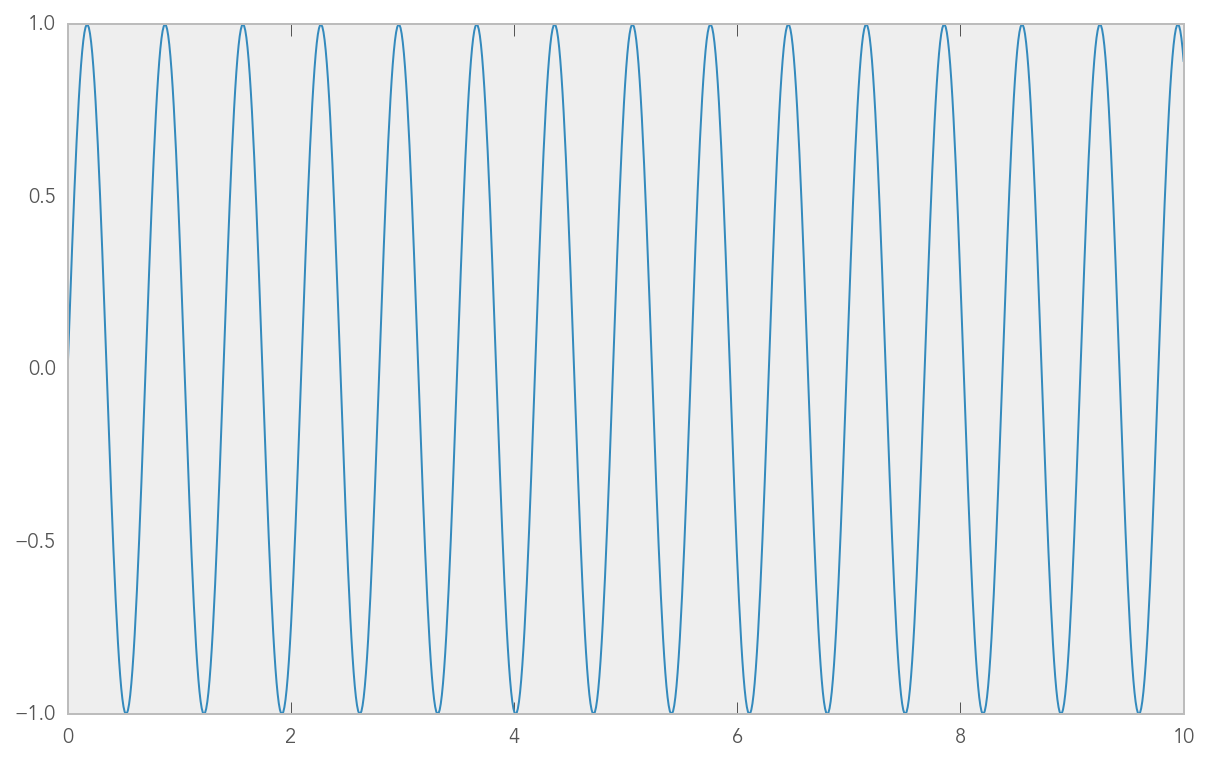

In [52]:
def stitch_data(ar, key):
    data = mpi_order(ar.data)
    parts = [ d[key] for d in data ]
    return np.concatenate(parts)
    

ar.wait(1)
while not ar.ready():
    clear_output(wait=True)
    x = stitch_data(ar, 'x')
    y = stitch_data(ar, 'y')
    plt.plot(x, y)
    plt.show()
    ar.wait(1)
    

In [45]:
ar.get()

CompositeError: one or more exceptions from call to method: execute
[0:execute]: NameError: name 'size' is not defined
[1:execute]: NameError: name 'size' is not defined
[2:execute]: NameError: name 'size' is not defined
[3:execute]: NameError: name 'size' is not defined